In [1]:
%matplotlib inline

In [4]:
!pip install sympy

  Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
  Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np

import sympy as sp
from sympy import symbols
from sympy.physics.units import meter, kilometer, second, hour, minute, kilogram, convert_to, quantities

from my_orbit_lib.extensions import * # strip_units, sp.Vector, sp.norm, np.norm

from datetime import datetime

import urllib.request

# Problem 1 - Numerical Integrator

Let's introduce the constants, I'll use the `sympy` physics package since this helps catch errors with the formulas. Basically any operations preserve the units used.

> **Note** (me from the future): This helped catch a lot of errors actually, although the speed is abysmal, so numpy is used for the real integrator.

In [6]:
MASS_OF_EARTH = 5.972e24 * kilogram
EARTH_RADIUS = 6371 * kilometer
G = 6.674e-11 * meter**3 * kilogram**-1 * second**-2

STANDARD_GRAVITATIONAL_PARAMETER_EARTH = MASS_OF_EARTH * convert_to(G, kilometer) 

The last constant is commonly seen as $\mu$ in Newton's formula for gravitation. This value calculated here for Earth closely resembles [sources on the internet](http://astro.vaporia.com/start/standardgravitationalparameter.html).

In [7]:
STANDARD_GRAVITATIONAL_PARAMETER_EARTH

398571.28*kilometer**3/second**2

## Euler Integration

Just to be simple, let's get something up and running as quickly as possible. In this case that means doing an Euler integration for the ODE:
$$\ddot{\vec{x}} = -\frac{\mu}{|\vec{x}|^2} (\frac{\vec{x}}{|\vec{x}|})$$

In [8]:
def solve_keplers_problem_euler(pos, vel, duration, h, nm=sp):
    """
    duration  How much into the future to integrate
    h         Time step
    """
    pos = pos.copy()
    vel = vel.copy()
    if duration == 0: return pos, vel 

    mu = STANDARD_GRAVITATIONAL_PARAMETER_EARTH
    if nm == np:
        mu = strip_units(mu)
    
    accel = lambda x: (-mu * x / nm.norm(x)**3)
    
    t = 0
    while t < duration:
        vel += h * accel(pos) 
        pos += h * vel
        t += h
    return pos, vel

In [9]:
pos_0 = sp.Vector([-5529.203, -2217.254, 3399.353]) * kilometer
vel_0 = sp.Vector([3.049295, 2.478617, 6.576514]) * kilometer/second

In [10]:
solve_keplers_problem_euler(pos_0, vel_0, 2*second, h=1e-1*second)

(Matrix([[-5523.09007225108*kilometer, -2212.29101851279*kilometer, 3412.49719927033*kilometer]]),
 Matrix([[3.06294760875871*kilometer/second, 2.48408885639651*kilometer/second, 6.56810054399326*kilometer/second]]))

Once we know the units are OK, we can run faster in numpy mode.

In [11]:
solve_keplers_problem_euler(strip_units(pos_0), strip_units(vel_0), 2, h=1e-1, nm=np)

(array([-5523.09007225, -2212.29101851,  3412.49719927]),
 array([3.06294761, 2.48408886, 6.56810054]))

To visualize, let's make a function we'll use a lot in the future. It has had a long lifecycle of tweaking side, but it essentially plots some numbers around a globe to see how a satellite would move.

In [12]:
def plot_trajectory(satellite, points, vel_arrow_scale=400, title='Trajectory Plot', x_view_angle=-75, y_view_angle=25, scale=0.7):
    """
    satellite  Should contain a tuple of the initial state (pos, vel)
    points     Should be an array of positions and velocities np.array((n, 2, 3))
    """
    
    fig = plt.figure()
    plt.title(title)
    ax = fig.add_subplot(1, 1, 1, projection=Axes3D.name)
    ax.view_init(y_view_angle, x_view_angle)
    ax.set_box_aspect((1, 1, 1))
    ax.grid(False)
    
    # Coordinate system arrows
    EARTH_RADIUS = 6371 # km
    r = EARTH_RADIUS * 0.8
    ax.quiver([0], [0], [0], [r], [0], [0], color='r', linewidth = 0.5)
    ax.quiver([0], [0], [0], [0], [r], [0], color='g', linewidth = 0.5)
    ax.quiver([0], [0], [0], [0], [0], [r], color='b', linewidth = 0.5)

    # Plot Earth
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = np.cos(u) * np.sin(v)
    y = np.sin(u) * np.sin(v)
    z = np.cos(v)

    r = EARTH_RADIUS
    ax.plot_wireframe(x * r, y * r, z * r, color=(0.1, 0.2, 0.5, 0.2), linewidth=0.5)

    # Plot satellite and velocity vector
    pos, vel = satellite
    pos, vel = strip_units(pos), strip_units(vel)
    vel *= vel_arrow_scale

    sat = ax.scatter([pos[0]], [pos[1]], [pos[2]], label="Satellite")
    ax.quiver([pos[0]], [pos[1]], [pos[2]], [vel[0]], [vel[1]], [vel[2]], color=sat.get_fc())

    # Plot points
    if points.shape[0] == 1:
        ax.scatter(points[:, 0, 0], points[:, 0, 1], points[:, 0, 2], '--', label="Trajectory", color="orange")
    else:
        ax.plot(points[:, 0, 0], points[:, 0, 1], points[:, 0, 2], '--', label="Trajectory", color="orange")
    
    plt.legend(loc='upper left', bbox_to_anchor=(1.3, 1), borderaxespad=0)

    # Rest of plot
    r = EARTH_RADIUS * scale
    ax.set_xlim(-r, r)
    ax.set_ylim(-r, r)
    ax.set_zlim(-r, r)
    
    ax.set_axis_off()
    fig.axes[0].get_xaxis().set_visible(False)
    fig.axes[0].get_yaxis().set_visible(False)
    plt.axis('off')

    plt.show()

In [13]:
def get_trajectory(pos, vel, duration, steps, h, method=solve_keplers_problem_euler):
    """
    Divides duration into steps and returns the integrated trajectory points.
    'h' is the time step that gets passed down to 'method'.
    """
    pos, vel = strip_units(pos), strip_units(vel)
    duration = strip_units(convert_to(duration, second))
    
    x, v = pos, vel
    points = np.empty((steps, 2, 3))
    for i in range(steps):
        x, v = method(x, v, duration=duration/steps, h=h, nm=np)
        points[i] = np.array([x, v])
    return points

In [14]:
n = get_trajectory(pos_0, vel_0, duration=1*hour, steps=100, h=1e-1)

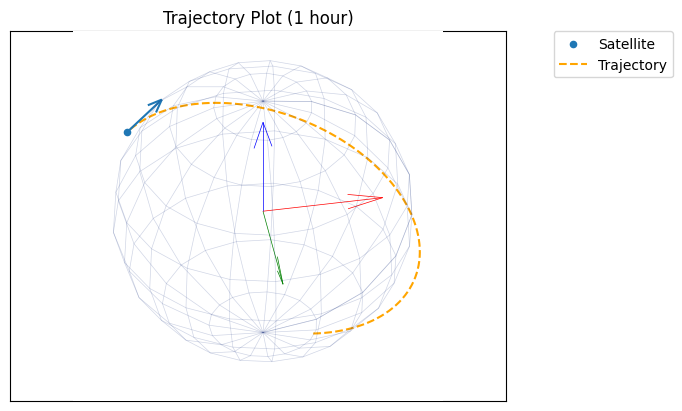

In [15]:
plot_trajectory((pos_0, vel_0), n, title='Trajectory Plot (1 hour)', x_view_angle=-80, y_view_angle=-40)

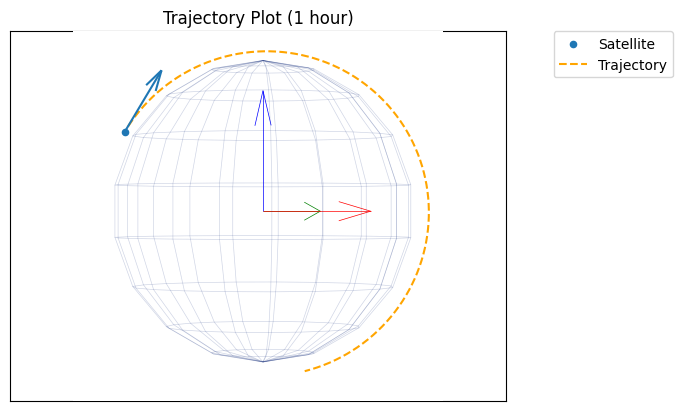

In [16]:
plot_trajectory((pos_0, vel_0), n, title='Trajectory Plot (1 hour)', x_view_angle=-60, y_view_angle=0)

### Analyzing the Orbit

Let's figure out if the numerical integrator is giving a reasonable result. The numerical integrator gave us around $2/3$ of an orbit for $1$ hour of travelling. Let's roughly compare that to a circular orbit at that altitude.

In [17]:
sp.norm(pos_0) - EARTH_RADIUS

487.8557306838*kilometer

In [18]:
T = 2 * np.pi * sp.norm(pos_0) / sp.norm(vel_0)
convert_to(T, minute)

93.7539988767441*minute

For a satellite at low earth orbit this seems reasonable and agrees with the visual plot.

### Error Bounds

[Dead end]\
To see how the error is introduced into Euler's method we can look at Taylor's theorem for a function $y$:

$$ y_{i+1} = y_i + y_i'h + \frac{y_i'h^2}{2} + ... $$

The first two terms are essentially Euler's step, while the third is bounded by the second derivative and $h^2$. This calculates the local truncation error, while the global truncation error is the contribution of all local errors. Since the number of steps for an interval $[a, b]$ is $(b-a)/h$, the global error is $O(h^2)/h = O(h)$ (this is not really rigorous, but intuitive, the formal proof I looked at was [here](https://personal.math.ubc.ca/~israel/m215/euler2/euler2.html)). So we know the error goes down linearly as we decrease the time step. For comparison Runge-Kutta 4th order has a global error $O(h^4)$.

A more accurate error bound on Euler's method is proved in [this lecture](https://youtu.be/T7W2c_czg5E?t=1750):

$$|y_{i+1} - w_{i+1}| \leq \frac{hM}{2L}(e^{(i+1)hL} - 1)$$
Where $L$ is the Lipschitz constant, and $M$ is the bound on the second derivative of the updated function...

Yeah. The more I looked into this the more I realized I don't know much higher-level math :D. Essentially later we have to take partial derivatives and introduce Jacobian matrices because we work with vectors... and...

### Invariants

...let's do something simpler. We know there are some some constants in our system, mainly the total energy and the angular momentum of our satellite. Any deviations from the true solution (like our numerical integrator will inevitably introduce) will result in those two quantities changing, and from a physical point of view we know they must be conserved.

In [19]:
sp.norm(vel_0) ** 2 / 2 - STANDARD_GRAVITATIONAL_PARAMETER_EARTH / sp.norm(pos_0)

-28.7643233740888*kilometer**2/second**2

In [20]:
sp.norm(pos_0.cross(vel_0))

52546.3014853733*kilometer**2/second

In [21]:
def get_specific_energy(x, v):
    return np.linalg.norm(v, axis=1) ** 2 / 2 - strip_units(STANDARD_GRAVITATIONAL_PARAMETER_EARTH) / np.linalg.norm(x, axis=1)

In [22]:
def get_specific_angular_momentum(x, v):
    return np.linalg.norm(np.cross(x, v), axis=1)

In [23]:
def integrate_and_plot_errors(x, v, period, steps, h, methods=[solve_keplers_problem_euler]):
    fig, (ax1, ax2) = plt.subplots(2)
    
    ax1.set_title('Energy error')
    ax1.set_xlabel('Time [h]')
    ax1.set_ylabel('Error [J]')
    ax2.set_title('Angular momentum error')
    ax2.set_xlabel('Time [h]')
    ax2.set_ylabel('Error [km^2 s^-1]')

    x_axis = np.linspace(0, strip_units(period), steps)
    E_0 = get_specific_energy([strip_units(x)], [strip_units(v)])
    h_0 = get_specific_angular_momentum([strip_units(x)], [strip_units(v)])[0]
    
    for method in methods:
        n = get_trajectory(x, v, duration=period, steps=steps, h=h, method=method)
        E = get_specific_energy(n[:, 0, :], n[:, 1, :])
        h_ = get_specific_angular_momentum(n[:, 0, :], n[:, 1, :])
        func_name = str(method).split()[1].split('_')[-1]
        ax1.plot(x_axis, np.abs(E_0 - E), label=func_name)
        ax2.plot(x_axis, np.abs(h_0 - h_), label=func_name)

    ax1.legend()
    ax2.legend()
        
    fig.tight_layout()
    
    plt.show()

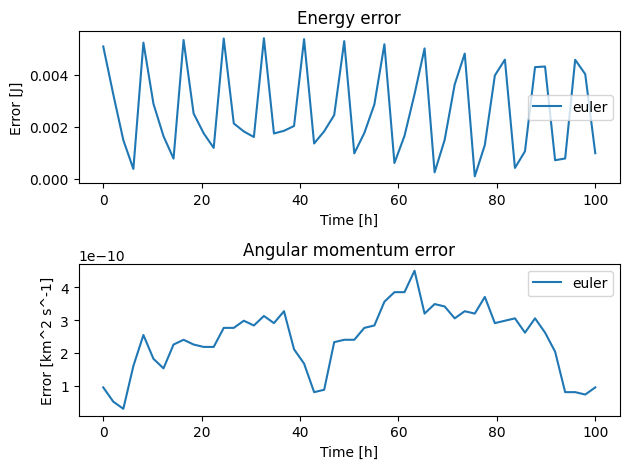

In [24]:
integrate_and_plot_errors(pos_0, vel_0, period = 100*hour, steps=50, h=1e1)

## Runge-Kutta

Now let's write a more popular integration method - 4th order Runge-Kutta and see how it compares. To adapt RK for a second-order ODE it's possible to transform the Kepler problem into a system of two first-order ODEs.

$$x''(t) = f(t, x(t), x'(t))$$
    
... by introducing a variable v:
    
$$x'(t) = v(t)$$
$$x''(t) = f(t, x(t), v(t))$$

In our case it's just:

$$x'(t) = v(t)$$
$$x''(t) = f(x(t))$$

The code below follows [this math article](https://mathworld.wolfram.com/Runge-KuttaMethod.html). 

In [25]:
def solve_keplers_problem_rk4(pos, vel, duration, h, nm=sp):
    """
    duration  How much in the future to integrate
    h         Time step
    """
    pos_0 = pos.copy()
    vel_0 = vel.copy()
    if duration == 0: return pos_0, vel_0 

    mu = STANDARD_GRAVITATIONAL_PARAMETER_EARTH
    if nm == np:
        mu = strip_units(mu)
    
    accel = lambda x: (-mu * x / nm.norm(x)**3)
    
    t_0 = 0
    while t_0 < duration:
        t_1 = t_0 + h / 2
        t_2 = t_0 + h / 2
        t_3 = t_0 + h
        
        k1x = h * vel_0
        k1v = h * accel(pos_0)

        k2x = h * (vel_0 + k1v / 2)
        k2v = h * accel(pos_0 + k1x / 2)

        k3x = h * (vel_0 + k2v / 2)
        k3v = h * accel(pos_0 + k2x / 2)

        k4x = h * (vel_0 + k3v)
        k4v = h * accel(pos_0 + k3x)
        
        pos_1 = pos_0 + (k1x + 2 * k2x + 2 * k3x + k4x) / 6
        vel_1 = vel_0 + (k1v + 2 * k2v + 2 * k3v + k4v) / 6
        
        pos_0 = pos_1
        vel_0 = vel_1
        t_0 = t_3
    return pos_0, vel_0

In [26]:
pos_0, vel_0

(Matrix([[-5529.203*kilometer, -2217.254*kilometer, 3399.353*kilometer]]),
 Matrix([[3.049295*kilometer/second, 2.478617*kilometer/second, 6.576514*kilometer/second]]))

In [27]:
solve_keplers_problem_rk4(pos_0, vel_0, duration=1*second, h=1e-1*second)

(Matrix([[-5525.84464425432*kilometer, -2214.52586498203*kilometer, 3406.58462319513*kilometer]]),
 Matrix([[3.0568055952174*kilometer/second, 2.48162786939918*kilometer/second, 6.57189017166318*kilometer/second]]))

Units are right, so the numpy version:

In [28]:
solve_keplers_problem_rk4(strip_units(pos_0), strip_units(vel_0), duration=1, h=1e-1, nm=np)

(array([-5525.84464425, -2214.52586498,  3406.5846232 ]),
 array([3.0568056 , 2.48162787, 6.57189017]))

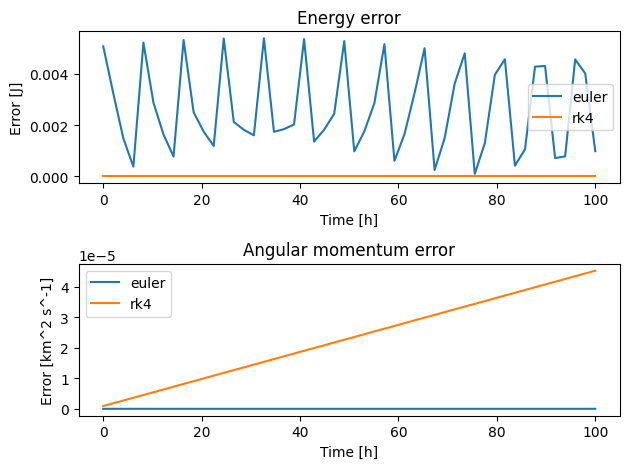

In [29]:
integrate_and_plot_errors(pos_0, vel_0, period = 100*hour, steps=50, h=1e1, methods=[solve_keplers_problem_euler, solve_keplers_problem_rk4])

So RK4 is doing a lot better on the energy error side, but for some reason Euler is not accumulating any angular momentum error. Maybe it's because of this specific orbit (which is nearly circular)? Let's try bumping up things a little.

In [30]:
pos_1 = pos_0 + sp.Vector([-5000*kilometer, 0, 0])
vel_1 = vel_0

In [31]:
pos_1, vel_1 

(Matrix([[-10529.203*kilometer, -2217.254*kilometer, 3399.353*kilometer]]),
 Matrix([[3.049295*kilometer/second, 2.478617*kilometer/second, 6.576514*kilometer/second]]))

In [32]:
n = get_trajectory(pos_1, vel_1, duration=20*hour, steps=100, h=1e-1)

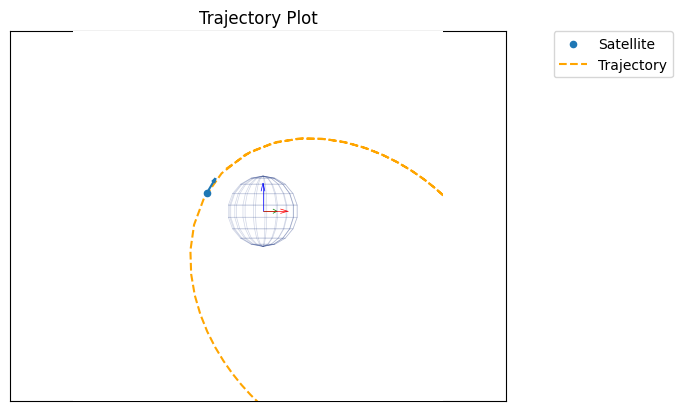

In [33]:
plot_trajectory((pos_1, vel_1), n, x_view_angle=-60, y_view_angle=0, scale=3)

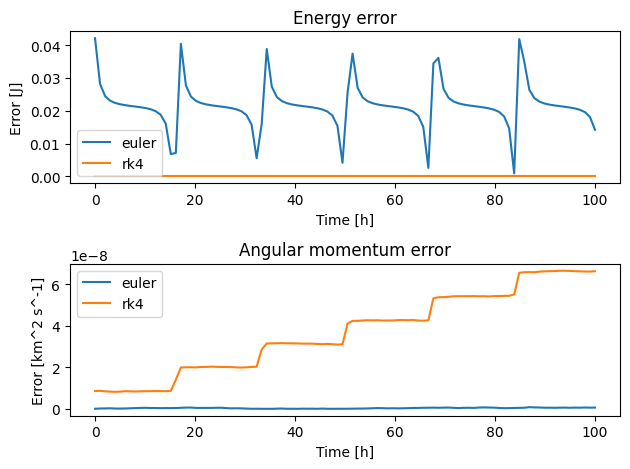

In [34]:
integrate_and_plot_errors(pos_1, vel_1, period = 100*hour, steps=100, h=1e1, methods=[solve_keplers_problem_euler, solve_keplers_problem_rk4])

Hm... How is Euler still beating RK4 on angular momentum? I'm probably missing something... We'll quantify the error more at the end of the notebook. But for now we at least have some idea how our algorithms are doing. :D

## Time

Until now we're dealing with a very handwavy notion of time. The current epoch is implicitly $t_0=0$ and just integrating $t$ seconds into the future. The problem is that in UTC world leap seconds exist. UTC in general likes to live in this sort of a limbo, keeping our notion of time of the calendar years, months and days while at the same time using atomic clocks for accurate measurement, but Earth's rotation likes to misbehave and often doesn't match up. Leap seconds are a way to reconcile the two. It's the only time system where 1 day doesn't necessarily have 86400 seconds.

Now our task is to see path of the satellite from 00:00:00 UTC on the 15th of January 2024 to 13:00:00 UTC the same day. Leap seconds here can't be a problem. They occur in the beginning of January or June anyway. (Plus we won't know yet if a leap second is supposed to be added next year).

For the sake of taking care of that problem in general, let's write a routine that transforms UTC into terestrial time (TT), and use that time delta for numerical integration. Let's store it as a Julian Date since we'll eventually need that too.

In [45]:
with open("leap-seconds.list") as file:
    leap_seconds_data = [l for l in [line.strip() for line in file.readlines()] if len(l) and l[0] != '#']

Don't judge me, I love handling files with Python one-liners. 

In [46]:
[l.split() for l in leap_seconds_data][:4]

[['2272060800', '10', '#', '1', 'Jan', '1972'],
 ['2287785600', '11', '#', '1', 'Jul', '1972'],
 ['2303683200', '12', '#', '1', 'Jan', '1973'],
 ['2335219200', '13', '#', '1', 'Jan', '1974']]

Only the first two parts are needed - the NTP time stamp and the number of leap seconds until there.

In [47]:
[l.split()[:2] for l in leap_seconds_data][:4]

[['2272060800', '10'],
 ['2287785600', '11'],
 ['2303683200', '12'],
 ['2335219200', '13']]

The downloaded leap seconds file provides documentation to convert NTP to MJD (Modified Julian Date) by the formula $t/86400 + 15020$. Then we convert it to JD by adding 2400000.5 (MJD 0.0 is equivalent to 1858-11-17T00:00:00).

In [48]:
3692217600/86400 + 15020 + 2400000.5

2457754.5

The above JDE is indeed 1 January 2017. Checked with the [US Naval Observeratory's converter](https://aa.usno.navy.mil/data/JulianDate).

In [49]:
LEAP_SECONDS_TABLE = {}
for ntp, seconds in [l.split()[:2] for l in leap_seconds_data]:
    LEAP_SECONDS_TABLE[int(ntp) / 86400 + 15020 + 2400000.5] = int(seconds)

In [50]:
def is_date_in_julian_calendar(year, month, day):
    # Pope Gregory XIII introduced the Gregorian calendar in 1582
    if (
        (year < 1582)
        or (year == 1582 and month < 10)
        or (year == 1582 and month == 10 and day < 5.0)
    ):
        return True

    if year >= 1926: # Turkey was the last to switch to the Gregorian calendar on 1 Jan
        return False 
    if year < 1926: 
        raise ValueError("Trying to convert the date " + 
                         str(datetime(year, month, day)) + " "
                         "but we don't know if it's in the Julian or Gregorian " +
                         "calendar, because that's country specific.")
        return None

In [51]:
def date_to_jd(year, month, day):
    """
    Algorithm from 'Practical Astronomy with your Calculator or Spreadsheet', 
        4th ed., Duffet-Smith and Zwart, 2011.

    Found the book in an online library 
    and the algorithm is 1:1.
    """
    if month == 1 or month == 2:
        yearp = year - 1
        monthp = month + 12
    else:
        yearp = year
        monthp = month

    julian = is_date_in_julian_calendar(year, month, day)
    if julian is not None and julian:
        B = 0
    else:
        A = np.trunc(yearp / 100.)
        B = 2 - A + np.trunc(A / 4.)

    if yearp < 0:
        C = np.trunc((365.25 * yearp) - 0.75)
    else:
        C = np.trunc(365.25 * yearp)
        
    D = np.trunc(30.6001 * (monthp + 1))
    
    jde = B + C + D + day + 1720994.5
    return jde

In [52]:
date_to_jd(2017, 1, 1) # Should get the same as above 2457754.5

2457754.5

In [53]:
def get_leap_seconds_from_jd(jd):
    jds_sorted = sorted(LEAP_SECONDS_TABLE.keys())

    # First test the extremes of the table
    if jd <= jds_sorted[0]:
        return 0
    if jd > jds_sorted[-1]:
        return LEAP_SECONDS_TABLE[jds_sorted[-1]]
    
    idx = 0
    while jd > jds_sorted[idx]:
        idx += 1
    return LEAP_SECONDS_TABLE[jds_sorted[idx - 1]]

In [54]:
get_leap_seconds_from_jd(date_to_jd(2017, 1, 1)), get_leap_seconds_from_jd(date_to_jd(2017, 1, 2))

(36, 37)

In [55]:
class Epoch:
    def __init__(self, *args, **kwargs):
        """
        Takes a JDE or a datetime.
        Internal time value is stored as a Julian Ephemeris Day.

        'datetime' is treated as UTC unless it's before 1972.
        If you want to deal with dates before that you should pass
        utc=False as an argument and assume it'll treat the date 
        as if it's in TT (terrestrial time).

        Before converting the datetime to JDE, let's convert UTC to TT,
        which requires some corrections:
        
        1. Taking into account all of the leap seconds from July 1972
        until today (calculated by using an up-to-date online file, but 
        for dates in the future it's unknown). 
        
        2. The resulting time is in TAI (atomic time). Assuming TAI has 
        been free of defects since it read 1977-01-01T00:00:00 then to convert
        TAI to TT an addition of 32.184s is needed.
        Source: https://www.ucolick.org/~sla/leapsecs/timescales.html
        """
        self.jde = 0
        if len(args) != 0:
            year, month, day = 0, 0, 0
            if isinstance(args[0], datetime):
                d = args[0]
                year, month, day, hours, minutes, sec = (
                    d.year,
                    d.month,
                    d.day,
                    d.hour,
                    d.minute,
                    d.second + d.microsecond / 1e6
                )
                # Convert hms to fractional day
                day += hours / 24. + minutes / 1440. + sec / 86400.

                jd = date_to_jd(year, month, day)

                utc_to_tt = None
                if 'utc' in kwargs: utc_to_tt = kwargs['utc']
                
                if year < 1972:
                    if utc_to_tt is not None:
                        raise ValueError("Can't do UTC before 1972. Pass utc=False as an argument and it'll treat the date as in TT (terrestrial time).")
                    utc_to_tt = False

                if utc_to_tt is None:
                    utc_to_tt = True

                delta_sec = 0
                if utc_to_tt:
                    delta_sec += 32.184
                    delta_sec += get_leap_seconds_from_jd(jd)
            
                self.jde = jd + delta_sec / 86400.
            elif isinstance(args[0], (int, float)):
                self.jde = float(args[0])
                return
            else:
                raise ValueError("Can't convert from " + str(args[0]))

        # Complain about extra args
        allowed_keywords = ['utc']
        for k, v in kwargs.items():
            if k not in allowed_keywords:
                raise ValueError('Unknown keyword arg ' + str(k) + '=' + str(v))

    def __str__(self):
        return str(self.jde)

    def __repr__(self):
        return "{}({})".format(self.__class__.__name__, self.jde)

In [56]:
Epoch(datetime(2017, 1, 1)), Epoch(datetime(2017, 1, 1), utc=False)

(Epoch(2457754.500789167), Epoch(2457754.5))

In [57]:
datetime.utcnow().isoformat(), Epoch(datetime.utcnow())

('2023-12-04T12:58:13.022901', Epoch(2460283.0412292466))

With all of that we can have a function that integrates an orbit between two points in time, handling dates and time properly. 

In [58]:
def get_trajectory_from_epochs(pos, vel, e1, e2, steps, h, method=solve_keplers_problem_rk4):
    """
    h   The time step that gets passed down to the integration method.
    e1  The epoch of the satellite.
    e2  Up until when to integrate.
    """
    assert(e2.jde > e1.jde)
    time_delta = (e2.jde - e1.jde) * 86400

    return get_trajectory(pos=pos, vel=vel, duration=time_delta, steps=steps, h=h, method=method)

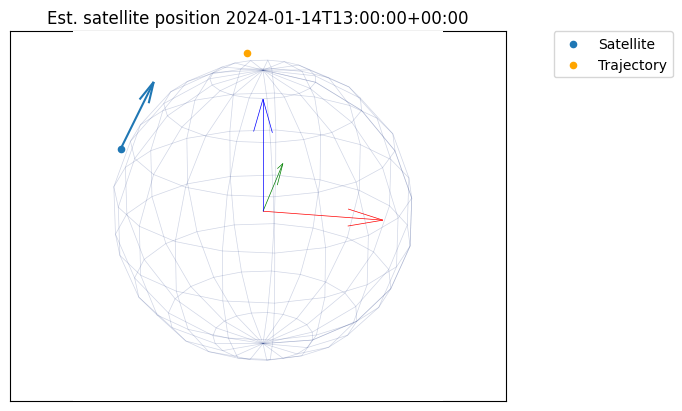

In [59]:
t1 = datetime.fromisoformat('2024-01-14T00:00:00+00:00')
t2 = datetime.fromisoformat('2024-01-14T13:00:00+00:00')
n = get_trajectory_from_epochs(pos_0, vel_0, Epoch(t1), Epoch(t2), steps=1, h=1e1)
plot_trajectory((pos_0, vel_0), n, title = f'Est. satellite position {t2.isoformat()}', x_view_angle = -80)

Est. position:

In [60]:
n[:, 0, :]

array([[-778.9893484 ,  629.33140511, 6816.28116995]])

## Idea for Reducing the Error

[Dead end]\
Here's an interesting idea, since we have precision "real-estate" (we are calculating relatively small kilometers - in the thousands), what happens if we keep the step size the same, but do the calculations in meters. My intuition tells me that essentially we'll have the same numbers but with more accuracy, since we've moved the decimal point.

In [61]:
def solve_keplers_problem_rk4_in_meters(pos, vel, duration, h, nm=np):
    pos = pos.copy() * 1000
    vel = vel.copy() * 1000

    global STANDARD_GRAVITATIONAL_PARAMETER_EARTH

    # Hack
    old = STANDARD_GRAVITATIONAL_PARAMETER_EARTH
    STANDARD_GRAVITATIONAL_PARAMETER_EARTH = convert_to(STANDARD_GRAVITATIONAL_PARAMETER_EARTH, meter)
    
    pos, vel = solve_keplers_problem_rk4(pos, vel, duration, h, nm=nm)
    
    STANDARD_GRAVITATIONAL_PARAMETER_EARTH = old
    
    return pos / 1000, vel / 1000

In [62]:
solve_keplers_problem_rk4(strip_units(pos_0), strip_units(vel_0), 1, 1e1, nm=np)

(array([-5498.36918703, -2192.3313998 ,  3464.90683763]),
 array([3.1174041 , 2.50585172, 6.53411858]))

In [63]:
solve_keplers_problem_rk4_in_meters(strip_units(pos_0), strip_units(vel_0), 1, 1e1)

(array([-5498.36918703, -2192.3313998 ,  3464.90683763]),
 array([3.1174041 , 2.50585172, 6.53411858]))

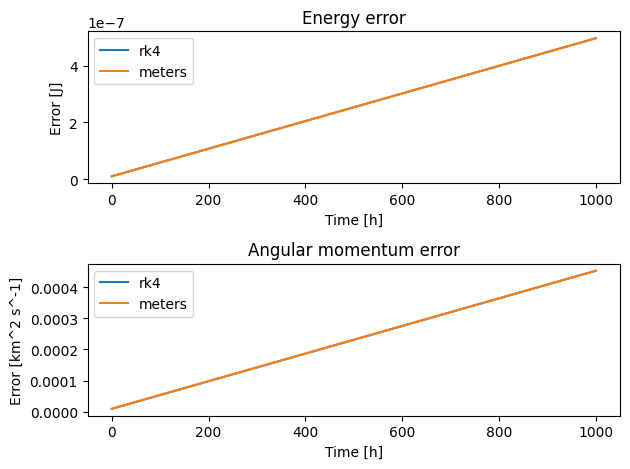

In [64]:
integrate_and_plot_errors(pos_0, vel_0, period = 1000*hour, steps=50, h=1e1, methods=[solve_keplers_problem_rk4, solve_keplers_problem_rk4_in_meters])

Seems like they are about the same.

## Energy Error and Positional Error

We can directly use the formula for the specific energy of an orbit (which is also how we get the SMA, one of the orbital elements):

$$\epsilon = -\frac{\mu}{2a}$$

to get an approximate error in the semi-major axis.

In [65]:
def integrate_and_plot_positional_error(x, v, period, steps, hs = [1e1], methods=[solve_keplers_problem_euler], start_x=0,end_y=0):
    fig, (ax1) = plt.subplots(1)
    
    ax1.set_title("Positional error in SMA")
    ax1.set_xlabel('Time [h]')
    ax1.set_ylabel('Error [m]')

    x_axis = np.linspace(0, strip_units(period), steps)
    E_0 = get_specific_energy([strip_units(x)], [strip_units(v)])
    a_0 = -strip_units(STANDARD_GRAVITATIONAL_PARAMETER_EARTH)/(2 * E_0) * 1000
        
    for method in methods:
        for h in hs:
            n = get_trajectory(x, v, duration=period, steps=steps, h=h, method=method)
            E = get_specific_energy(n[:, 0, :], n[:, 1, :])
        
            a_err = -strip_units(STANDARD_GRAVITATIONAL_PARAMETER_EARTH)/(2 * E) * 1000
            func_name = "_".join(str(method).split()[1].split('_')[3:]) + " h=" + str(h)
            ax1.plot(x_axis, np.abs(a_0 - a_err), label=func_name)
    
    _, right = ax1.get_xlim()
    ax1.set_xlim(start_x, max(x_axis))
    if end_y != 0:
        ax1.set_ylim(0, end_y)
    ax1.relim()
    ax1.autoscale_view()
    
    ax1.legend()
    fig.tight_layout()
    plt.show()

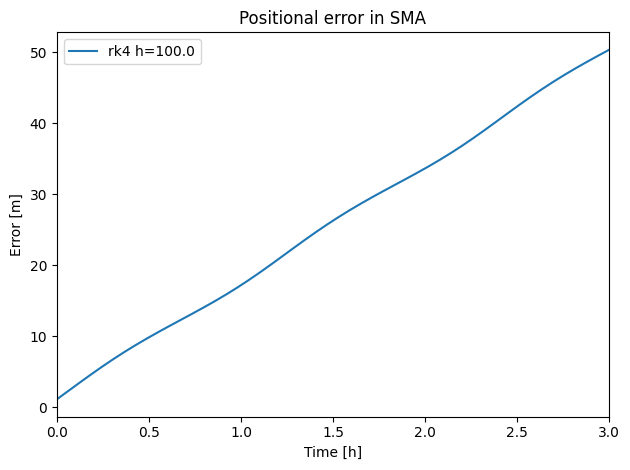

In [66]:
integrate_and_plot_positional_error(pos_0, vel_0, period = 3*hour, steps=50, hs=[1e2], methods=[solve_keplers_problem_rk4])

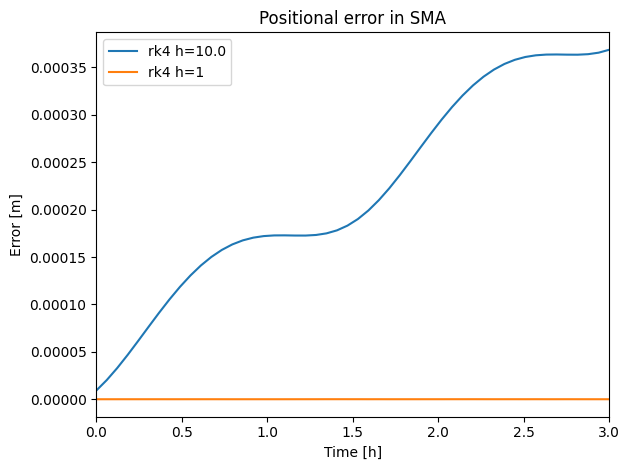

In [67]:
integrate_and_plot_positional_error(pos_0, vel_0, period = 3*hour, steps=50, hs=[1e1, 1], methods=[solve_keplers_problem_rk4])

### What h Should I Choose?

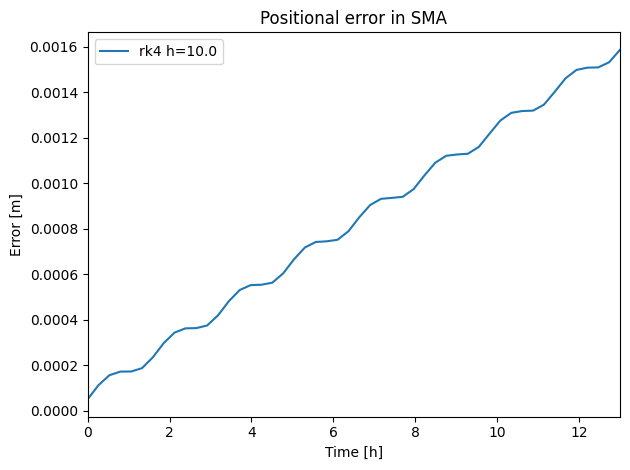

In [68]:
integrate_and_plot_positional_error(pos_0, vel_0, period = 13*hour, steps=50, hs=[1e1], methods=[solve_keplers_problem_rk4])

So the approximate error for our satellite revolving for 13 hours with $h=10$ is around $1\ cm$. $h=10$ seems to be barely good enough with error potentially building up quickly (considering the fact it's also a very stable system and would likely blow up more if more stuff was happening). So to be safe $h=1$ or lower seems to be the way to go. 

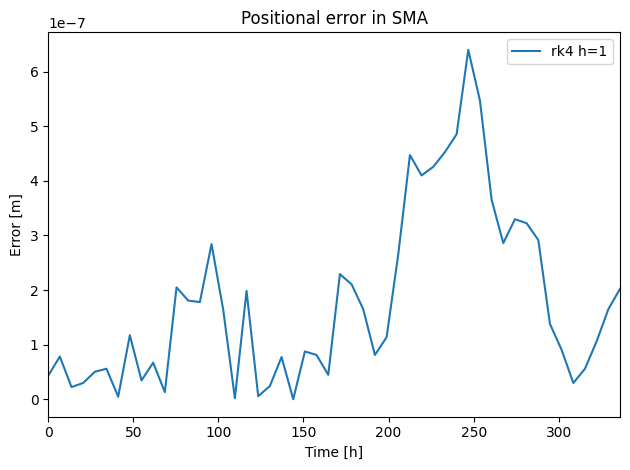

In [69]:
integrate_and_plot_positional_error(pos_0, vel_0, period = 2*7*24*hour, steps=50, hs=[1], methods=[solve_keplers_problem_rk4])

This honestly seems more than enough precision. We can even be fancy and roll up a RK4 implementation which does automatic step size adjustment by using a error estimation mid-evaluation. But for now I think we're ok.

> Note: This implementation with the automatic step-size adjustment magically appears in the Problem 2 notebook.

## References

* mathplotlib, sympy and numpy documentation
* Standard gravitational parameter, http://astro.vaporia.com/start/standardgravitationalparameter.html
* Euler error, https://personal.math.ubc.ca/~israel/m215/euler2/euler2.html
* Proof for Euler's method error bound, https://youtu.be/T7W2c_czg5E?t=1750
* RK4 article, https://mathworld.wolfram.com/Runge-KuttaMethod.html
* US Naval Observatory's JD calculator, https://aa.usno.navy.mil/data/JulianDate

Time is complicated:
* https://eclipse.gsfc.nasa.gov/LEcat5/time.html
* http://www.astro.sunysb.edu/fwalter/PHY515/times.html#ut
* Steve Allen, Time Scales, https://www.ucolick.org/~sla/leapsecs/timescales.html (This book honestly sent me down a rabit hole)